# Imports 

In [96]:
%matplotlib inline
import pickle
import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from functools import reduce
from sklearn import ensemble
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

In [39]:
try:
    df = pickle.load(df, open( "data.pickle", "wb" ))
except:
    df = pd.read_csv('CrowdstormingDataJuly1st.csv', parse_dates = ['birthday'])
    pickle.dump(df, open( "data.pickle", "wb" ))

## Structure of the data

Every row corresponds to a (player, referee) pair.
The table can be seen as a join of tree tables:
* a table describing player attributes only,
* table describing referee attributes only ,
* table describing (player, referee) pair attributes only.

In other words every attribute is a function of
* `playerShort`
* or `refNum`
* or `(playerShort, refNum)` pair.

We will check now that the data meets this assumption because further code relies on it.

In [112]:
def functionAttrsFor(df, colname):
    """Find attributes whose value may be uniquely inferred from `colname` attribute value.
       Returns a boolean Series object with colnames as indices.
       If value for a given attribute is true then this attribute a function of `colname` attribute.
    """
    return df.groupby(colname).agg(lambda col: col.nunique(dropna=False) == 1).apply(all)

playerAttrs  = functionAttrsFor(df.drop('refNum', axis=1), 'playerShort')
refereeAttrs = functionAttrsFor(df.drop('playerShort', axis=1), 'refNum')
otherAttrs = ~(playerAttrs | refereeAttrs)

attributes = list(zip(
    ['playerShort', 'refNum', '(playerShort, refNum)'],
    map(lambda x: list(x[x].index), [playerAttrs, refereeAttrs, otherAttrs])
))

for x in attributes:
    template = "Following attributes are a function of {}:"
    print(template.format(x[0]))
    print('\n'.join(x[1]))
    print('')

Following attributes are a function of playerShort:
player
club
leagueCountry
birthday
height
weight
position
photoID
rater1
rater2

Following attributes are a function of refNum:
refCountry
Alpha_3
meanIAT
nIAT
seIAT
meanExp
nExp
seExp

Following attributes are a function of (playerShort, refNum):
games
victories
ties
defeats
goals
yellowCards
yellowReds
redCards



In [126]:
any(df.duplicated(['playerShort', 'refNum']))

False

These functional dependencies agree with the data description.
Moreover, `(playerShort, refNum)` pair is a primary key for this table.

# Cleaning

We first drop players that don't have a skin rating (which is caused by the absence of their photo).

In [43]:
template = "We drop {:.0f}% of observations because they don't have a photo."
percentage = 100 * df.photoID.isnull().sum() / len(df)
print(template.format(percentage))

df = df[df.photoID.notnull()]

if any(df['rater1'].isnull()) or any(df['rater2'].isnull()):
    print("Some players with a photo lack a skin rating.")
else:
    print("All other observations have non-null skin ratings.")

We drop 15% of observations because they don't have a photo.
All other observations have non-null skin ratings.


In [7]:
# abs(df['rater1'] - df['rater2'])
# c = sns.color_palette()
# jitter_x = np.random.normal(0, 0.04, size=len(df.rater1))
# jitter_y = np.random.normal(0, 0.04, size=len(df.rater2))
# For the time being it runs too long when we rerun everything :P.
#sns.jointplot(df.rater1 + jitter_x, df.rater2 + jitter_y, kind='kde')


As can be observed in the jointplot above, the only real difference in rating is between the 2 lightests colors). Since we cannot determine the skin color of a player where the 2 raters are different, we drop those observations.

In [8]:
# drop all players (so rows) that don't have the same skin color rating
# print ('we drop ' + str(round(100*df[df['rater1'] != df['rater2']].count()[1] / df.count()[1], 2)) + '% of observation because they don\'t have the same rating')
# df = df[df['rater1'] == df['rater2']]

Let's check if there are more missing values in any column.

In [46]:
df.apply(pd.isnull, axis=0).sum()

playerShort        0
player             0
club               0
leagueCountry      0
birthday           0
height             0
weight             0
position           0
games              0
victories          0
ties               0
defeats            0
goals              0
yellowCards        0
yellowReds         0
redCards           0
photoID            0
rater1             0
rater2             0
refNum             0
refCountry         0
Alpha_3            1
meanIAT          153
nIAT             153
seIAT            153
meanExp          153
nExp             153
seExp            153
dtype: int64

We see that there are a few missing values.
We can simply drop the players that don't have a height or weight 
and the referees without bias score (not many observations).
Since there are a lot of players without a position we create a category for them.

In [123]:
# Drop players without reported height.
df = df[df['height'].notnull()]
# Drop players without reported weight.
df = df[df['weight'].notnull()]
# Drop the referees without bias score data.
df = df[df['meanIAT'].notnull()]

# Create a noPosition category for players without a position.
df.loc[df['position'].isnull(), 'position'] = 'noPosition'

if df.notnull().values.all():
    print("All NA values has already been removed.")

All NA values has already been removed.


# Feature generation

We aggregate the information on the player level.

In [14]:
print(df.keys())
print(df.position.value_counts())

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')
Center Back             20534
Center Forward          16612
Defensive Midfielder    13924
Goalkeeper              11015
Attacking Midfielder    10779
Left Fullback            8980
Right Fullback           8426
noPosition               8265
Left Midfielder          6214
Right Winger             5146
Center Midfielder        4835
Right Midfielder         4637
Left Winger              4501
Name: position, dtype: int64


In [15]:
positionArray = list(df['position'].unique())
df['positionNum'] = list(map(positionArray.index, df['position']))

countryArray = list(df['leagueCountry'].unique())
df['countryNum'] = list(map(countryArray.index, df['leagueCountry']))

In [16]:
def genFeatures(player):
    sample = player.iloc(0)[0] # used to get general infos
    
    age = relativedelta(datetime.datetime.now(), sample['birthday']).years
    
    bmi = sample['weight'] / pow(sample['height']/100, 2)
    games = player['games'].sum()
    winRate = player['victories'].sum() / games
    tiesRate = player['ties'].sum() / games
    loseRate = player['defeats'].sum() / games
    yellowRedsRate = player['yellowReds'].sum() / games
    yellowRate = player['yellowCards'].sum() / games
    redRate = player['redCards'].sum() / games
    IAT = (player['meanExp'] * player['games']).sum()/games
    Exp = (player['meanIAT'] * player['games']).sum()/games
    IAT2 = player['meanExp'].mean()
    Exp2 = player['meanIAT'].mean()
    seIAT = math.sqrt((player['nIATs * pow(player['seIAT'],2)).sum()) / (player['nIAT'].sum())
    seExp = math.sqrt((player['nExp'] * pow(player['seExp'],2)).sum()) / (player['nExp'].sum())

    yellowRateRacistIAT = (player['yellowCards'] * (player['meanIAT'] > 0.35)).sum() / (1e-3+(player['games'] * (player['meanIAT'] > 0.35)).sum())
    yellowRateNonRacistIAT = (player['yellowCards'] * (player['meanIAT'] < 0.35)).sum() / (1e-3+(player['games'] * (player['meanIAT'] < 0.35)).sum())
    racismIAT = yellowRateRacistIAT / (1e-3+yellowRateNonRacistIAT)
    yellowRateRacistExp = (player['yellowCards'] * (player['meanExp'] > 0.5)).sum() / (1e-3+(player['games'] * (player['meanExp'] > 0.5)).sum())
    yellowRateNonRacistExp = (player['yellowCards'] * (player['meanExp'] < 0.5)).sum() / (1e-3+(player['games'] * (player['meanExp'] < 0.5)).sum())
    racismExp = yellowRateRacistExp / (1e-3+yellowRateNonRacistExp)
    
    position = sample['positionNum']
    goalRatio = player['goals'].sum() / games
    
    # TODO some feature with the goal ratio AND offensive position
    
    return pd.Series({
            'player': sample['player'], # constant
            'age': age,
            'height': sample['height'],
            'weight': sample['weight'], 
            'bmi': bmi,
            'country': sample['countryNum'],
            'games': games,
            'winRate': winRate,
            'tiesRate': tiesRate,
            'loseRate': loseRate,
            'yellowRate': yellowRate,
            'yellowRedsRate': yellowRedsRate,
            'yellowOverRed': redRate/(yellowRate+1e-3),
            'redRate': redRate,
            'skinColor': (sample['rater1'] + sample['rater2'])/2, # we only keep players where rater1 == rater2
            'goalRatio': goalRatio,
            'IAT': IAT,
            'Exp': Exp,
            'IAT2': IAT2,
            'Exp2': Exp2,
            'seIAT': seIAT,
            'seExp': seExp,
            'racismIAT': racismIAT,
            'racismExp': racismExp,
            'position': position,
            })

players = df.groupby('playerShort').apply(genFeatures)
players


,Exp,Exp2,IAT,IAT2,age,bmi,country,games,goalRatio,height,...,redRate,seExp,seIAT,skinColor,tiesRate,weight,winRate,yellowOverRed,yellowRate,yellowRedsRate
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.333195,0.346459,0.400637,0.494575,37,21.434609,2,654,0.013761,182.0,...,0.000000,4.155690e-07,6.680331e-08,0.125,0.273700,71.0,0.377676,0.000000,0.029052,0.000000
aaron-hunt,0.341438,0.348818,0.380811,0.449220,30,21.798202,3,336,0.184524,183.0,...,0.002976,1.630653e-07,3.620245e-08,0.125,0.217262,73.0,0.419643,0.023621,0.125000,0.000000
aaron-lennon,0.332389,0.345893,0.399459,0.491482,29,23.140496,2,412,0.075243,165.0,...,0.000000,3.239259e-07,5.878861e-08,0.250,0.235437,63.0,0.485437,0.000000,0.026699,0.000000
aaron-ramsey,0.336638,0.346821,0.433294,0.514693,25,23.986870,2,260,0.150000,178.0,...,0.003846,4.289817e-07,1.092870e-07,0.000,0.161538,76.0,0.576923,0.031990,0.119231,0.000000
abdelhamid-el-kaoutari,0.331882,0.331600,0.328895,0.335587,26,22.530864,1,124,0.008065,180.0,...,0.016129,5.330254e-06,1.476342e-06,0.250,0.322581,73.0,0.330645,0.246184,0.064516,0.032258
abdou-traore_2,0.327985,0.320079,0.317247,0.296562,28,22.839506,1,97,0.030928,180.0,...,0.000000,3.769416e-06,1.281884e-06,0.750,0.237113,74.0,0.422680,0.000000,0.113402,0.010309
abdoulaye-diallo_2,0.343556,0.341625,0.428271,0.400818,24,22.395790,1,24,0.000000,189.0,...,0.000000,3.439109e-06,8.437459e-07,0.875,0.333333,80.0,0.333333,0.000000,0.000000,0.000000
abdoulaye-keita_2,0.348498,0.355406,0.390184,0.417225,26,23.483477,1,3,0.000000,188.0,...,0.000000,2.207109e-05,5.478587e-06,0.875,0.333333,83.0,0.000000,0.000000,0.000000,0.000000
abdoulwhaid-sissoko,0.344130,0.348178,0.402314,0.429630,26,20.987654,1,121,0.024793,180.0,...,0.016529,1.904677e-06,4.724571e-07,1.000,0.206612,68.0,0.280992,0.094692,0.173554,0.000000


In [17]:
y = players['skinColor'] >= 0.5 # 2 classes, {0, 0.25}-> white (no racial bias) and {0.5, 0.75, 1} -> black (racial bias)
features = [
    'games',
    'goalRatio',
    'country',
    'age',
    'bmi',
    'height',
    'weight',
    'yellowRate',
    'yellowRedsRate',
    'redRate',
    'yellowOverRed', 
    'winRate',
    'loseRate',
    'tiesRate',
    'IAT',
    'Exp',
    'IAT2',
    'Exp2',
    'seIAT',
    'seExp',
    'racismIAT',
    'racismExp',
    'position',
]
X = players[features]

In [147]:
#Standardize features
X_std = X.sub(X.mean(), axis=1).div(X.std(), axis = 1)

# generate the final test set
# we stratify so that we have the same class proportion in both train and test set
X_w, X_val, y_w, y_val = train_test_split(X_std, y, test_size=0.25, random_state=0, stratify = y)
X_w = np.asanyarray(X_w)

# Model Training
## we decided to use binary classification with skinColor {0, 0.25}-> white (no racial bias) and {0.5, 0.75, 1} -> black (racial bias)

In [120]:
# first element of the tuple is the accuracy, second is F1
def scorer(estimator, X_test, y_test, X_train, y_train):
    pred = estimator.predict(X_test)
    A = metrics.accuracy_score(y_test, pred)
    #print(metrics.classification_report(y, pred))
    F1 = metrics.f1_score(y_test, pred)
    
    #Added for learning curve
    pred_train = estimator.predict(X_train)
    A_train = metrics.accuracy_score(y_train, pred_train)
    F1_Train = metrics.f1_score(y_train, pred_train)
    
    return (A, F1, A_train, F1_Train)

def CVstep(model, X, y, train_index, test_index, scorer):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    estimator = model.fit(X_train, y_train)
    return scorer(estimator, X_test, y_test, X_train, y_train)

# takes an array of models and return their cross-validation results for each split
# uses the same splits for each model so they can be directly compared
def CV(modelData, scorer, folds):
    kf = cross_validation.KFold(len(X_w), n_folds = folds)
    return [[CVstep(model, X, y, train_index, test_index, scorer) for model, X, y in modelData] for train_index, test_index in kf]


In [121]:
# balanced so that we do not neglect black values and only predict white

# gini vs entropy comparison
rf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = None, min_samples_split = 20, criterion = 'gini', class_weight = 'balanced')
rf2 = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = None, min_samples_split = 20, criterion = 'entropy', class_weight = 'balanced')

# cross-validation (average over 5 different 10-fold splits to smooth the result)
scores = np.concatenate(np.asarray([CV([[rf, X_w, y_w], [rf2, X_w, y_w]], scorer, 10) for i in range(0, 5)]))

#     cross_validation.cross_val_score (rf, X_train, y_train, scoring = scorer, cv = 10)
#     score.mean()

In [122]:
print(scores[:, 0, 0].mean()) # acc of first model
print(scores[:, 1, 0].mean()) # acc of second model

print(scores[:, 0, 1].mean()) # f1 of first model
print(scores[:, 1, 1].mean()) # f1 of second model

0.76952194698
0.773087063596
0.472105842771
0.468612018803


We don't see a real difference between the 2

# Bonus:
## Check how n_estimator affect learning curve
### We plot cost of train and CV error versus increasing values of n_estimators (grid_search in usual terms)

In [125]:
rfs = list()

num_model = 20

for n in range(1, num_model):
    rf = ensemble.RandomForestClassifier(n_estimators = n * 5, max_depth = None, min_samples_split = 20, criterion = 'gini', class_weight = 'balanced')
    rf_tot = [rf, X_w, y_w]
    rfs.append(rf_tot)

scores_n_estimator = np.concatenate(np.asarray([CV(np.array(rfs), scorer, 20) for i in range(0, 3)] ))


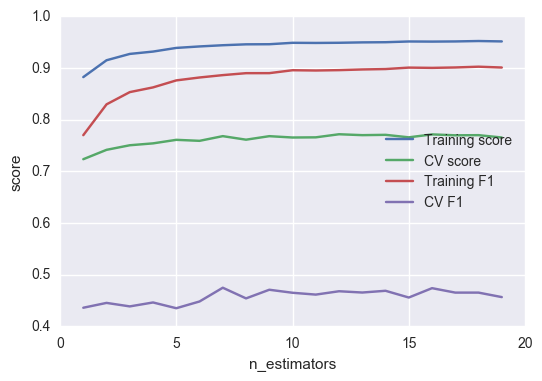

In [140]:
# Compute accury values for each model
train_scores = list()
cv_scores = list()
train_F1 = list()
test_F1 = list()

num_model = scores_n_estimator.shape[1]

for n in range(0, num_model):
    cv_scores.append(scores_n_estimator[:, n, 0].mean())
    test_F1.append(scores_n_estimator[:, n, 1].mean())
    train_scores.append(scores_n_estimator[:, n, 2].mean())
    train_F1.append(scores_n_estimator[:, n, 3].mean())
    
# Build Graph
axisRange = np.linspace(1, (num_model)*1, num_model)

fig, ax = plt.subplots()

ax.plot(axisRange, train_scores, label='Training score')
ax.plot(axisRange, cv_scores, label='CV score')
ax.plot(axisRange, train_F1, label='Training F1 ')
ax.plot(axisRange, test_F1, label='CV F1')

# Now add the legend with some customizations.
legend = ax.legend(loc='center right', shadow=True)

plt.xlabel('n_estimators')
plt.ylabel('score')


## Check how min_sample_split affect learning curve
### We plot cost of train and CV error versus increasing values of n_estimators (grid_search in usual terms)

In [143]:
rfs = list()

num_model = 100

for n in range(1, num_model):
    rf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = None, min_samples_split = 2*n, criterion = 'gini', class_weight = 'balanced')
    rf_tot = [rf, X_w, y_w]
    rfs.append(rf_tot)

scores_min_samples_split = np.concatenate(np.asarray([CV(np.array(rfs), scorer, 20) for i in range(0, 3)] ))


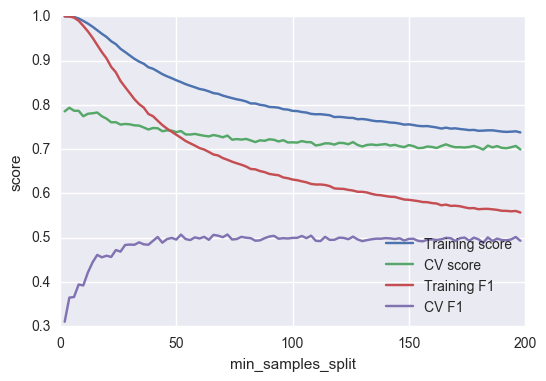

In [145]:
# Compute accury values for each model
train_scores = list()
cv_scores = list()
train_F1 = list()
test_F1 = list()

num_model = scores_min_samples_split.shape[1]

for n in range(0, num_model):
    cv_scores.append(scores_min_samples_split[:, n, 0].mean())
    test_F1.append(scores_min_samples_split[:, n, 1].mean())
    train_scores.append(scores_min_samples_split[:, n, 2].mean())
    train_F1.append(scores_min_samples_split[:, n, 3].mean())
    
# Build Graph
axisRange = np.linspace(2, (num_model)*2, num_model)

fig, ax = plt.subplots()

ax.plot(axisRange, train_scores, label='Training score')
ax.plot(axisRange, cv_scores, label='CV score')
ax.plot(axisRange, train_F1, label='Training F1 ')
ax.plot(axisRange, test_F1, label='CV F1')

# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=True)

plt.xlabel('min_samples_split')
plt.ylabel('score')


## We can see that as we increase the min_samples_split variable, we underfit. 

# Final model

In [22]:
rf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = None, min_samples_split = 20, criterion = 'gini', class_weight = 'balanced')

rf.fit(X_w, y_w)
pred = rf.predict(X_val)
A = metrics.accuracy_score(y_val, pred)
print('A = ' + str(A))
F1 = metrics.f1_score(y_val, pred)
print('F1 = ' + str(F1))

print(metrics.classification_report(y_val, pred))




A = 0.771794871795
F1 = 0.502793296089
             precision    recall  f1-score   support

      False       0.84      0.86      0.85       296
       True       0.53      0.48      0.50        94

avg / total       0.76      0.77      0.77       390




## TODO disccus feature importance and try some feature that overfit? as  asked in the readme

In [23]:
rf.feature_importances_

array([ 0.04234447,  0.03563922,  0.05749232,  0.0392346 ,  0.04162596,
        0.032513  ,  0.0299909 ,  0.0375996 ,  0.02116727,  0.02467637,
        0.0194763 ,  0.04359237,  0.03778172,  0.03536679,  0.08072033,
        0.08808638,  0.09264165,  0.07934383,  0.00997714,  0.04135333,
        0.0357444 ,  0.03717918,  0.03645288])